In [1]:
!pip install -U ultralytics --no-deps -q

import os
import shutil
import random
import cv2
import yaml
import glob
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import ultralytics
from ultralytics import YOLO
from pathlib import Path
from tqdm.notebook import tqdm

print(f"Ultralytics Version: {ultralytics.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

Ultralytics Version: 8.3.237
CUDA Available: True


In [2]:
# --- Configuration ---
SEED = 42
img_size = 640
FIXMATCH_THRESHOLD = 0.95  # Strict threshold for FixMatch
device = 0 # '0' for GPU, 'cpu' for CPU

# Original Paths (Kaggle Input)
ORIG_TRAIN_IMG = '/kaggle/input/pillsegmentation/train/images'
ORIG_TRAIN_LBL = '/kaggle/input/pillsegmentation/train/labels'
ORIG_VAL_IMG = '/kaggle/input/pillsegmentation/valid/images'
ORIG_TEST_IMG = '/kaggle/input/pillsegmentation/test/images'

# Working Directory Paths
WORK_DIR = '/kaggle/working/dataset_fixmatch'
LABELED_DIR = os.path.join(WORK_DIR, 'labeled_20')
UNLABELED_DIR = os.path.join(WORK_DIR, 'unlabeled_80')
PSEUDO_DIR = os.path.join(WORK_DIR, 'fixmatch_combined')

# Create Directories
for d in [LABELED_DIR, UNLABELED_DIR, PSEUDO_DIR]:
    os.makedirs(os.path.join(d, 'images'), exist_ok=True)
    os.makedirs(os.path.join(d, 'labels'), exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(SEED)
print("Setup & FixMatch Configuration Complete.")

Setup & FixMatch Configuration Complete.


In [3]:
def preprocess_and_save(img_path, save_path):
    """Reads image, applies CLAHE (Contrast), saves to new location."""
    img = cv2.imread(img_path)
    if img is None: return False
    
    # Convert to LAB, apply CLAHE to L-channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    cv2.imwrite(save_path, final)
    return True

In [4]:
# --- Splitting Logic ---
all_train_images = sorted(glob.glob(os.path.join(ORIG_TRAIN_IMG, '*')))
random.shuffle(all_train_images)

split_idx = int(len(all_train_images) * 0.2) # 20% Labeled
labeled_imgs = all_train_images[:split_idx]
unlabeled_imgs = all_train_images[split_idx:]

print(f"Total Images: {len(all_train_images)}")
print(f"Labeled (Teacher Train): {len(labeled_imgs)}")
print(f"Unlabeled (For FixMatch): {len(unlabeled_imgs)}")

Total Images: 6549
Labeled (Teacher Train): 1309
Unlabeled (For FixMatch): 5240


In [5]:
# 1. Process Labeled Data (20%)
print("Processing Labeled Data...")
for img_path in tqdm(labeled_imgs):
    basename = os.path.basename(img_path)
    lbl_name = basename.rsplit('.', 1)[0] + '.txt'
    src_lbl = os.path.join(ORIG_TRAIN_LBL, lbl_name)
    
    preprocess_and_save(img_path, os.path.join(LABELED_DIR, 'images', basename))
    if os.path.exists(src_lbl):
        shutil.copy(src_lbl, os.path.join(LABELED_DIR, 'labels', lbl_name))

Processing Labeled Data...


  0%|          | 0/1309 [00:00<?, ?it/s]

In [6]:
# 2. Process Unlabeled Data (80%) - Images ONLY
print("Processing Unlabeled Data...")
for img_path in tqdm(unlabeled_imgs):
    basename = os.path.basename(img_path)
    preprocess_and_save(img_path, os.path.join(UNLABELED_DIR, 'images', basename))

Processing Unlabeled Data...


  0%|          | 0/5240 [00:00<?, ?it/s]

In [7]:
# 1. Clear any old YOLO cache files
print("Clearing old cache files...")
for cache_file in glob.glob(os.path.join(LABELED_DIR, 'labels', '*.cache')):
    os.remove(cache_file)

# 2. Create Teacher YAML
teacher_yaml = {
    'path': WORK_DIR,
    'train': os.path.join(LABELED_DIR, 'images'),
    'val': ORIG_VAL_IMG,
    'test': ORIG_TEST_IMG,
    'names': {0: 'pill'} 
}
with open('teacher_data.yaml', 'w') as f:
    yaml.dump(teacher_yaml, f)

Clearing old cache files...


In [8]:
# 3. Train Teacher
print("--- Starting Teacher Training (20% Data) ---")
teacher_model = YOLO('yolov8s-seg.pt') 

teacher_results = teacher_model.train(
    data='teacher_data.yaml',
    epochs=30,
    imgsz=img_size,
    batch=16,
    patience=10,
    project='fixmatch_project',
    name='teacher_run',
    exist_ok=True,
    augment=True, # Standard augmentation for teacher
    
    workers=0,      
    cache=False,    
    amp=False,      
    verbose=True
)
print("Teacher Training Finished.")

--- Starting Teacher Training (20% Data) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=teacher_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.971      0.963       0.98      0.959      0.972      0.964      0.982       0.92
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/fixmatch_project/teacher_run
Teacher Training Finished.


In [9]:
print("--- Evaluating Teacher Performance ---")
best_teacher = YOLO('fixmatch_project/teacher_run/weights/best.pt')
metrics_t = best_teacher.val(data='teacher_data.yaml', split='test')

print("\n" + "="*40)
print(f"TEACHER RESULTS (Baseline):")
print(f"Mask mAP@0.5:      {metrics_t.seg.map50:.4f}")
print(f"Mask mAP@0.5:0.95: {metrics_t.seg.map:.4f}")
print("="*40 + "\n")

--- Evaluating Teacher Performance ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.7±2.0 MB/s, size: 49.2 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 142.0it/s 2.1s0.1s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.5it/s 5.4s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.965       0.97      0.978      0.964      0.968      0.973      0.983      0.922
Speed: 1.9ms preprocess, 6.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/runs/segment/val

TEACHER RESULTS (Baseline):
Mask mAP@0.5:      0.9834
Mask mAP@0.5:0.95: 0.9219



In [10]:
print(f"--- Generating Pseudo Labels (FixMatch Threshold: {FIXMATCH_THRESHOLD}) ---")

unlabeled_images_list = glob.glob(os.path.join(UNLABELED_DIR, 'images', '*'))
pseudo_count = 0

for img_path in tqdm(unlabeled_images_list):
    # Predict using "Weak" view (Standard Inference)
    # iou=0.7 prevents duplicate boxes, conf=FIXMATCH_THRESHOLD filters low quality
    results = best_teacher.predict(img_path, conf=FIXMATCH_THRESHOLD, iou=0.7, verbose=False)
    result = results[0]
    
    # Prepare Save Path
    basename = os.path.basename(img_path)
    txt_name = basename.rsplit('.', 1)[0] + '.txt'
    save_path = os.path.join(UNLABELED_DIR, 'labels', txt_name)
    
    # Only save if masks detected (FixMatch High Confidence Check)
    if result.masks is not None:
        with open(save_path, 'w') as f:
            for i, box in enumerate(result.boxes):
                cls = int(box.cls[0])
                segments = result.masks.xyn[i] # Normalized Polygon
                
                # YOLO Format: class x1 y1 x2 y2 ...
                line = f"{cls} " + " ".join([f"{coord:.6f}" for coord in segments.flatten()])
                f.write(line + "\n")
        pseudo_count += 1

print(f"FixMatch Labeling complete. {pseudo_count}/{len(unlabeled_images_list)} images passed the threshold.")

--- Generating Pseudo Labels (FixMatch Threshold: 0.95) ---


  0%|          | 0/5240 [00:00<?, ?it/s]

FixMatch Labeling complete. 3400/5240 images passed the threshold.


In [11]:
print("Cleaning up GPU memory...")
if 'teacher_model' in globals(): del teacher_model
if 'best_teacher' in globals(): del best_teacher
if 'student_model' in globals(): del student_model
gc.collect()
torch.cuda.empty_cache()
print(f"GPU Memory Cleared. Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

Cleaning up GPU memory...
GPU Memory Cleared. Allocated: 0.06 GB


In [12]:
import os
import glob
import shutil
from tqdm.notebook import tqdm

# --- 1. DEFINE PATHS (Ensure these match your Config) ---
WORK_DIR = '/kaggle/working/dataset_fixmatch'
LABELED_DIR = os.path.join(WORK_DIR, 'labeled_20')
UNLABELED_DIR = os.path.join(WORK_DIR, 'unlabeled_80')
PSEUDO_DIR = os.path.join(WORK_DIR, 'fixmatch_combined')

# --- 2. CLEAR & RE-CREATE DESTINATION FOLDERS ---
if os.path.exists(PSEUDO_DIR):
    shutil.rmtree(PSEUDO_DIR) # WIPE IT CLEAN

os.makedirs(os.path.join(PSEUDO_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(PSEUDO_DIR, 'labels'), exist_ok=True)

print(f"📂 Created empty folder: {PSEUDO_DIR}")

# --- 3. COPY LABELED DATA (Teacher Data) ---
print("Copying Labeled Data (Teacher Set)...")
labeled_imgs = glob.glob(os.path.join(LABELED_DIR, 'images', '*'))

for img_path in tqdm(labeled_imgs):
    basename = os.path.basename(img_path)
    label_name = basename.rsplit('.', 1)[0] + '.txt'
    src_lbl = os.path.join(LABELED_DIR, 'labels', label_name)
    
    # Copy Image
    shutil.copy(img_path, os.path.join(PSEUDO_DIR, 'images', basename))
    # Copy Label (if exists)
    if os.path.exists(src_lbl):
        shutil.copy(src_lbl, os.path.join(PSEUDO_DIR, 'labels', label_name))

# --- 4. COPY PSEUDO-LABELED DATA (Unlabeled Set) ---
print("Copying Pseudo-Labeled Data...")
pseudo_labels = glob.glob(os.path.join(UNLABELED_DIR, 'labels', '*'))

count = 0
for lbl_path in tqdm(pseudo_labels):
    # Only copy if the label file is NOT empty
    if os.path.getsize(lbl_path) > 0:
        basename_lbl = os.path.basename(lbl_path)
        basename_img_no_ext = basename_lbl.rsplit('.', 1)[0]
        
        # Find matching image (could be .jpg, .png, etc.)
        possible_images = glob.glob(os.path.join(UNLABELED_DIR, 'images', basename_img_no_ext + '.*'))
        
        if len(possible_images) > 0:
            src_img = possible_images[0]
            dst_img = os.path.join(PSEUDO_DIR, 'images', os.path.basename(src_img))
            dst_lbl = os.path.join(PSEUDO_DIR, 'labels', basename_lbl)
            
            shutil.copy(src_img, dst_img)
            shutil.copy(lbl_path, dst_lbl)
            count += 1

# --- 5. VERIFICATION ---
total_images = len(glob.glob(os.path.join(PSEUDO_DIR, 'images', '*')))
print("\n" + "="*40)
print(f"✅ Student Dataset Ready!")
print(f"📍 Location: {PSEUDO_DIR}/images")
print(f"📊 Total Images Found: {total_images}")
print("="*40)

if total_images == 0:
    print("❌ ERROR: Still 0 images. Please check your LABELED_DIR and UNLABELED_DIR paths.")
else:
    print("👉 You can now run the Student Training cell.")

📂 Created empty folder: /kaggle/working/dataset_fixmatch/fixmatch_combined
Copying Labeled Data (Teacher Set)...


  0%|          | 0/1309 [00:00<?, ?it/s]

Copying Pseudo-Labeled Data...


  0%|          | 0/3400 [00:00<?, ?it/s]


✅ Student Dataset Ready!
📍 Location: /kaggle/working/dataset_fixmatch/fixmatch_combined/images
📊 Total Images Found: 4709
👉 You can now run the Student Training cell.


In [14]:
import os
import yaml

# --- 1. Define FixMatch Paths ---
# These must match the paths used in your earlier cells
WORK_DIR = '/kaggle/working/dataset_fixmatch'
PSEUDO_DIR = os.path.join(WORK_DIR, 'fixmatch_combined')
ORIG_VAL_IMG = '/kaggle/input/pillsegmentation/valid/images'
ORIG_TEST_IMG = '/kaggle/input/pillsegmentation/test/images'

# --- 2. Check if Images Exist (Safety Check) ---
train_img_dir = os.path.join(PSEUDO_DIR, 'images')
if not os.path.exists(train_img_dir) or len(os.listdir(train_img_dir)) == 0:
    print(f"⚠️ WARNING: The folder '{train_img_dir}' appears empty or missing!")
    print("You might need to re-run the 'Create Student Dataset' cell (Cell 11) first.")
else:
    print(f"✅ Verified: Found images in {train_img_dir}")

# --- 3. Create the YAML File ---
student_yaml = {
    'path': WORK_DIR,  # Base working directory
    'train': os.path.join(PSEUDO_DIR, 'images'),
    'val': ORIG_VAL_IMG,
    'test': ORIG_TEST_IMG,
    'names': {0: 'pill'}  # Class name
}

# Save it to the current directory
yaml_path = 'student_data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(student_yaml, f)

print(f"✅ Success! Created configuration file: {yaml_path}")
print("👉 You can now run the Student Training cell.")

✅ Verified: Found images in /kaggle/working/dataset_fixmatch/fixmatch_combined/images
✅ Success! Created configuration file: student_data.yaml
👉 You can now run the Student Training cell.


In [15]:
print("--- Starting Student Training (Strong Augmentation) ---")

# 1. Clear cache
for cache_file in glob.glob(os.path.join(PSEUDO_DIR, 'labels', '*.cache')):
    if os.path.exists(cache_file): os.remove(cache_file)

# 2. Load Student Model
student_model = YOLO('yolov8m-seg.pt') 

# 3. Train Student with Aggressive Augmentations
student_results = student_model.train(
    data='student_data.yaml',
    epochs=30,
    imgsz=img_size,
    batch=16,        
    patience=15,
    project='fixmatch_project',
    name='student_run',
    exist_ok=True,
    
    workers=0,      
    amp=False,      
    cache=False,    
    verbose=True,
    
    # --- FIXMATCH STRONG AUGMENTATIONS ---
    augment=True,
    mosaic=1.0,        # Strong Geometric distortion (100% prob)
    mixup=0.15,        # Image mixing (15% prob)
    copy_paste=0.3,    # Segment Copy-Paste (30% prob - Crucial for Seg)
    degrees=15.0,      # Rotation
    translate=0.2,     # Translation
    scale=0.6,         # Scaling
    fliplr=0.5,        # Horizontal Flip
    hsv_h=0.02,        # Color Jitter
    hsv_s=0.7,
    hsv_v=0.4
    # -------------------------------------
)
print("Student Training Finished.")

--- Starting Student Training (Strong Augmentation) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=student_data.yaml, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=student_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.952      0.974      0.981      0.945      0.953      0.977      0.982      0.915
Speed: 0.2ms preprocess, 13.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/fixmatch_project/student_run
Student Training Finished.


In [16]:
# --- Evaluation ---
print("--- Loading Best Weights for Evaluation ---")
best_teacher = YOLO('fixmatch_project/teacher_run/weights/best.pt')
best_student = YOLO('fixmatch_project/student_run/weights/best.pt')

print("\n--- Calculating Metrics on Test Set ---")
metrics_t = best_teacher.val(data='teacher_data.yaml', split='test', verbose=False)
metrics_s = best_student.val(data='student_data.yaml', split='test', verbose=False)

print("\n" + "="*60)
print(f"{'METRIC':<25} | {'TEACHER (20%)':<15} | {'FIXMATCH STUDENT':<15}")
print("-" * 60)
print(f"{'mAP@0.5 (Mask)':<25} | {metrics_t.seg.map50:<15.4f} | {metrics_s.seg.map50:<15.4f}")
print(f"{'mAP@0.5:0.95 (Mask)':<25} | {metrics_t.seg.map:<15.4f}    | {metrics_s.seg.map:<15.4f}")
print("="*60 + "\n")

--- Loading Best Weights for Evaluation ---

--- Calculating Metrics on Test Set ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients
val: Fast image access ✅ (ping: 1.4±0.5 ms, read: 106.9±39.7 MB/s, size: 50.5 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 627.8it/s 0.5s0.1s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.5it/s 5.4s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.965       0.97      0.978      0.964      0.968      0.973      0.983      0.922
Speed: 2.1ms preprocess, 6.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/runs/segment/val2
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 86.5±56.6 MB/s, size: 35.6 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 841.1it/s 0.3s0.1s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P   

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.946      0.976      0.975      0.945       0.95      0.979      0.979      0.906
Speed: 2.0ms preprocess, 13.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /kaggle/working/runs/segment/val3

METRIC                    | TEACHER (20%)   | FIXMATCH STUDENT
------------------------------------------------------------
mAP@0.5 (Mask)            | 0.9834          | 0.9789         
mAP@0.5:0.95 (Mask)       | 0.9219             | 0.9059         



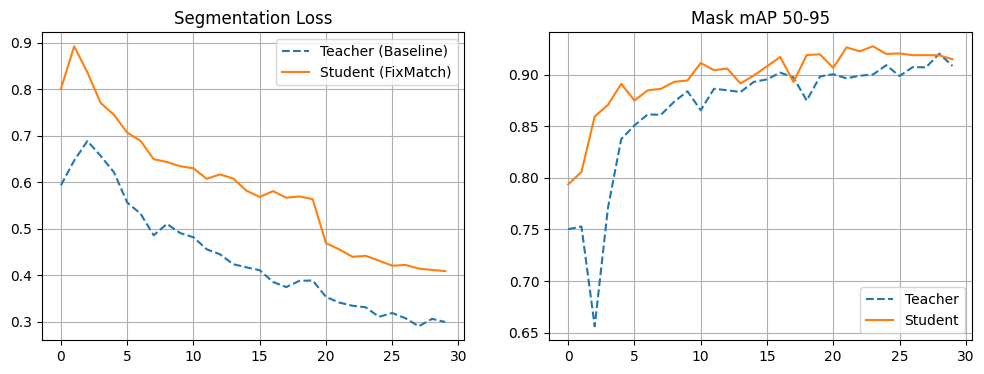

--- Visualizing Comparison: Teacher vs. FixMatch Student ---


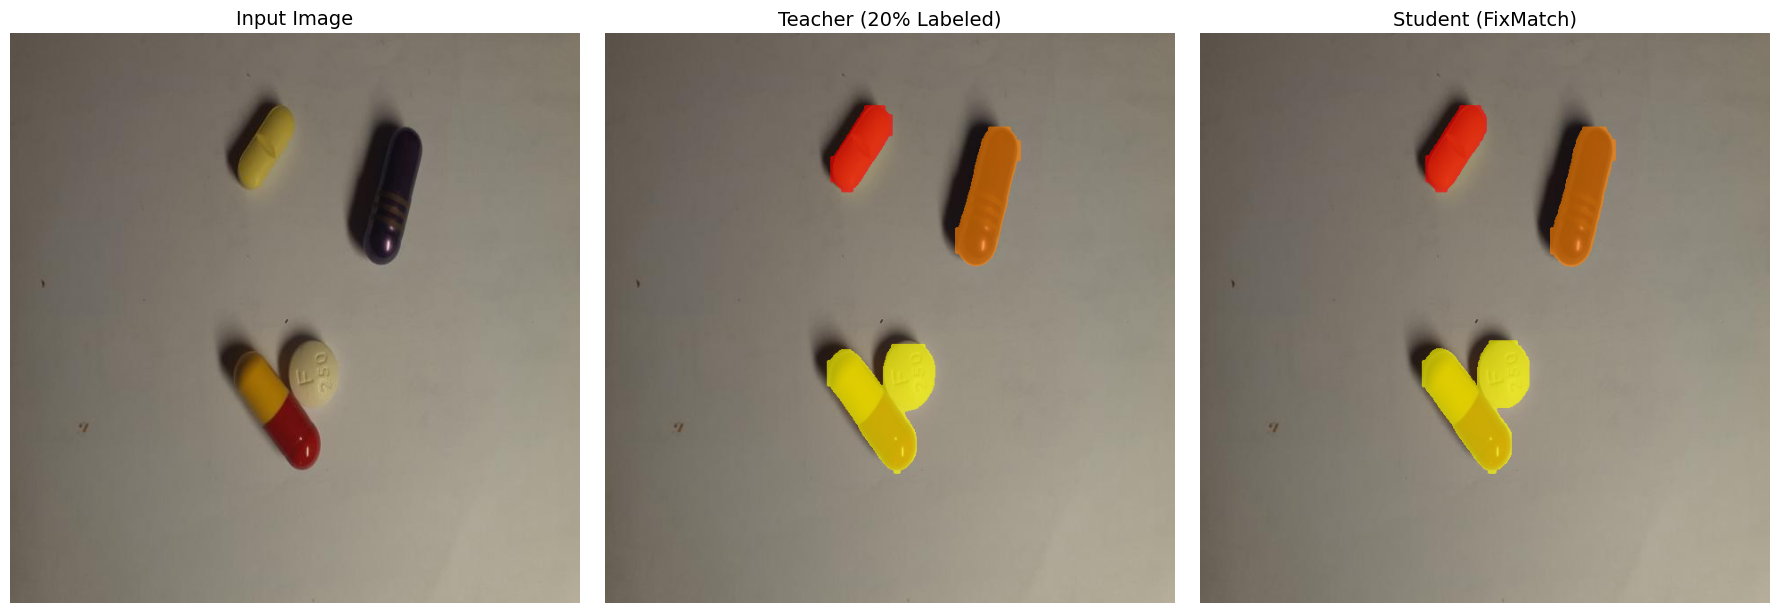

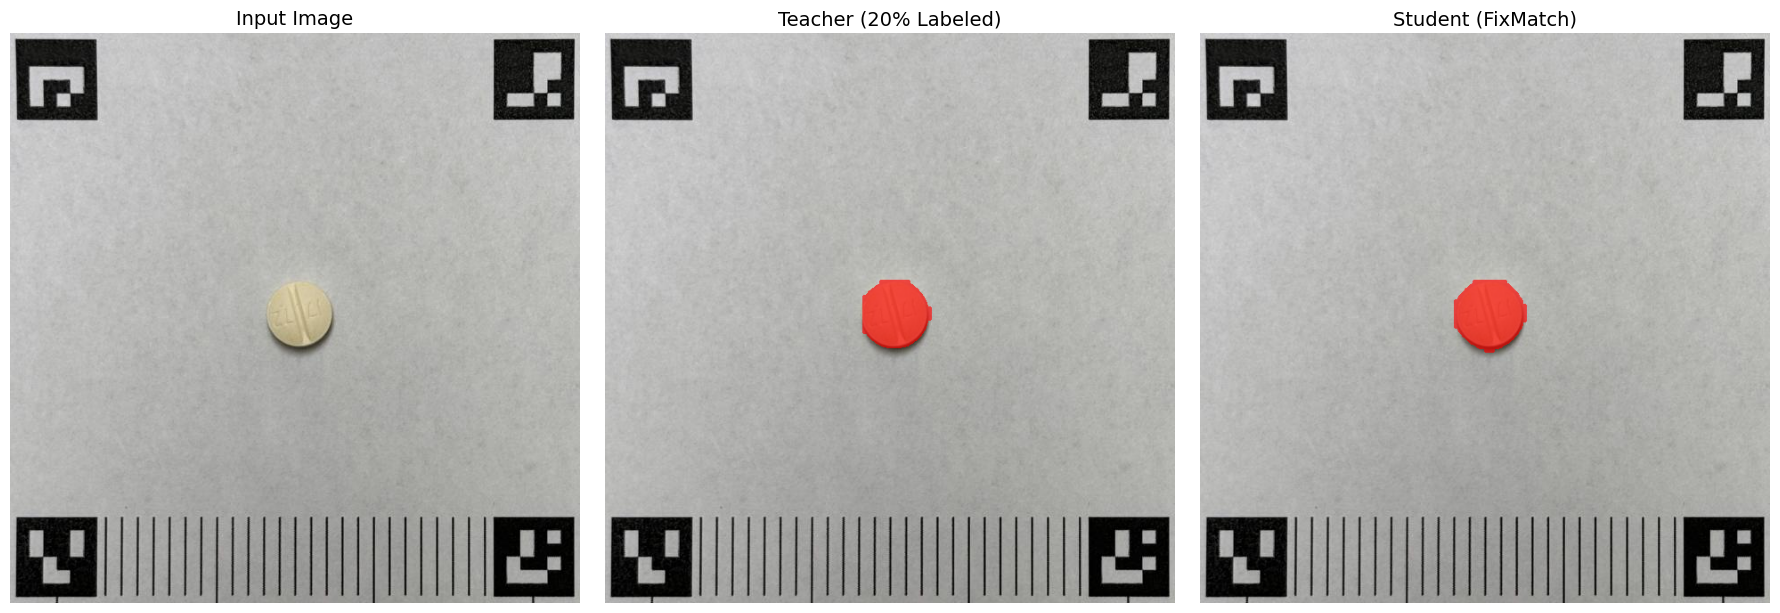

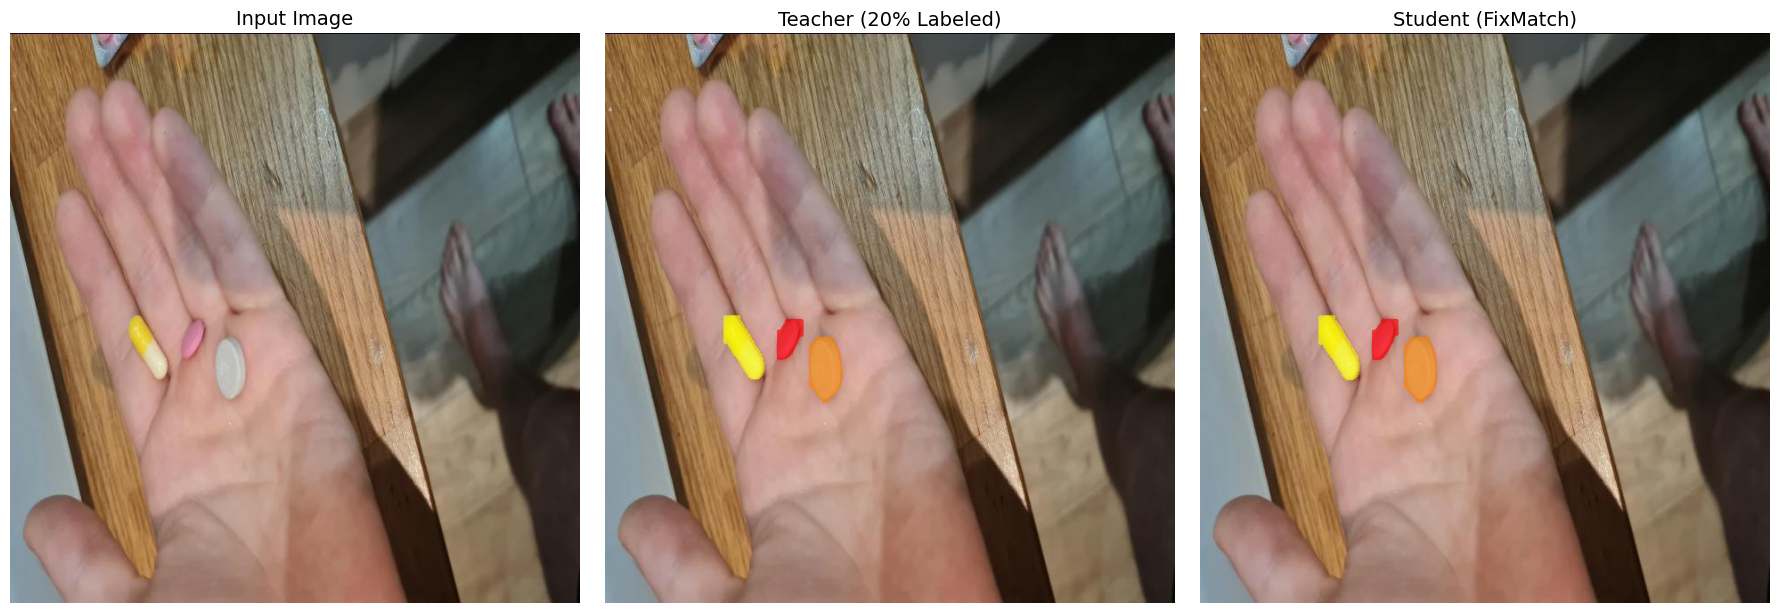

In [17]:
# --- Plot Loss Curves ---
try:
    t_df = pd.read_csv('fixmatch_project/teacher_run/results.csv')
    s_df = pd.read_csv('fixmatch_project/student_run/results.csv')
    t_df.columns = t_df.columns.str.strip()
    s_df.columns = s_df.columns.str.strip()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t_df['train/seg_loss'], label='Teacher (Baseline)', linestyle='--')
    plt.plot(s_df['train/seg_loss'], label='Student (FixMatch)')
    plt.title('Segmentation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_df['metrics/mAP50-95(M)'], label='Teacher', linestyle='--')
    plt.plot(s_df['metrics/mAP50-95(M)'], label='Student')
    plt.title('Mask mAP 50-95')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Could not plot loss curves: {e}")

# --- Visual Comparison Function ---
def get_colored_mask_image(model, img_path):
    img = cv2.imread(img_path)
    if img is None: return np.zeros((640,640,3), dtype=np.uint8)
    
    results = model.predict(img_path, verbose=False, conf=0.25)
    result = results[0]
    overlay = img.copy()
    colors = [(0, 0, 255), (0, 255, 255), (0, 128, 255)]
    
    if result.masks is not None:
        for i, contour in enumerate(result.masks.xy):
            if len(contour) > 0:
                color = colors[i % len(colors)]
                cnt = contour.astype(np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(overlay, [cnt], color)
                cv2.polylines(overlay, [cnt], isClosed=True, color=color, thickness=2)
    
    cv2.addWeighted(overlay, 0.65, img, 0.35, 0, img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("--- Visualizing Comparison: Teacher vs. FixMatch Student ---")
test_samples = glob.glob(os.path.join(ORIG_TEST_IMG, '*'))
samples = random.sample(test_samples, 3)

for img_path in samples:
    orig_img = cv2.imread(img_path)
    orig_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    teacher_vis = get_colored_mask_image(best_teacher, img_path)
    student_vis = get_colored_mask_image(best_student, img_path)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(orig_rgb)
    axes[0].set_title("Input Image", fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(teacher_vis)
    axes[1].set_title("Teacher (20% Labeled)", fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(student_vis)
    axes[2].set_title("Student (FixMatch)", fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

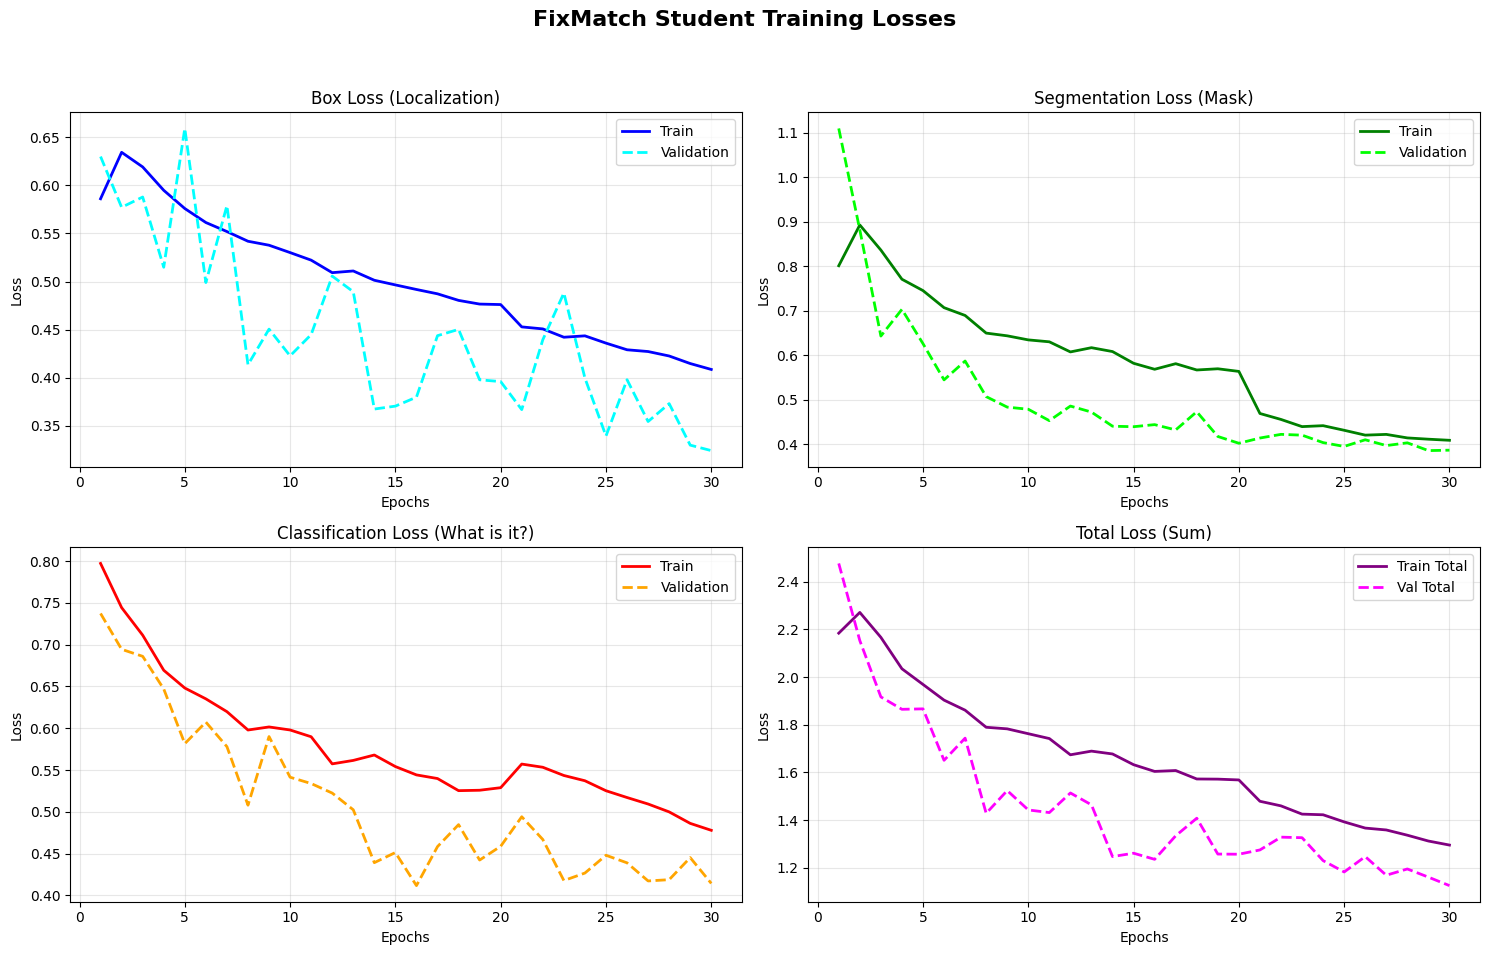

--- Final Epoch Statistics ---
Train Box Loss: 0.4086 | Val Box Loss: 0.3241
Train Seg Loss: 0.4088 | Val Seg Loss: 0.3866
Train Cls Loss: 0.4779 | Val Cls Loss: 0.4144


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
# Path to your FixMatch Student results
# Verify this matches your project_name and name in the train() function
RESULTS_PATH = 'fixmatch_project/student_run/results.csv'

def plot_fixmatch_losses(csv_path):
    if not os.path.exists(csv_path):
        print(f"❌ Error: Could not find results file at {csv_path}")
        print("Check if the training has started and the path is correct.")
        return

    # 1. Load Data
    df = pd.read_csv(csv_path)
    # Clean column names (remove extra spaces)
    df.columns = df.columns.str.strip()
    
    # 2. Calculate Total Loss (YOLOv8 sums these internally)
    # Note: dfl_loss is also part of training loss usually, but we focus on the main 3.
    # We will sum the available components for a 'Total' view.
    df['train/total_loss'] = df['train/box_loss'] + df['train/seg_loss'] + df['train/cls_loss']
    df['val/total_loss'] = df['val/box_loss'] + df['val/seg_loss'] + df['val/cls_loss']

    # 3. Plotting
    epochs = df['epoch']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('FixMatch Student Training Losses', fontsize=16, fontweight='bold')

    # Helper function for plotting
    def plot_metric(ax, metric_name, title, color_train, color_val):
        ax.plot(epochs, df[f'train/{metric_name}'], label='Train', color=color_train, linewidth=2)
        ax.plot(epochs, df[f'val/{metric_name}'], label='Validation', color=color_val, linestyle='--', linewidth=2)
        ax.set_title(title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # A. Box Loss (Bounding Box regression)
    plot_metric(axes[0, 0], 'box_loss', 'Box Loss (Localization)', 'blue', 'cyan')

    # B. Segmentation Loss (Mask accuracy)
    plot_metric(axes[0, 1], 'seg_loss', 'Segmentation Loss (Mask)', 'green', 'lime')

    # C. Classification Loss (Object Class accuracy)
    plot_metric(axes[1, 0], 'cls_loss', 'Classification Loss (What is it?)', 'red', 'orange')

    # D. Total Loss (Sum of above)
    axes[1, 1].plot(epochs, df['train/total_loss'], label='Train Total', color='purple', linewidth=2)
    axes[1, 1].plot(epochs, df['val/total_loss'], label='Val Total', color='magenta', linestyle='--', linewidth=2)
    axes[1, 1].set_title('Total Loss (Sum)')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 4. Print Final Epoch Stats
    last_row = df.iloc[-1]
    print("--- Final Epoch Statistics ---")
    print(f"Train Box Loss: {last_row['train/box_loss']:.4f} | Val Box Loss: {last_row['val/box_loss']:.4f}")
    print(f"Train Seg Loss: {last_row['train/seg_loss']:.4f} | Val Seg Loss: {last_row['val/seg_loss']:.4f}")
    print(f"Train Cls Loss: {last_row['train/cls_loss']:.4f} | Val Cls Loss: {last_row['val/cls_loss']:.4f}")

# Run the function
plot_fixmatch_losses(RESULTS_PATH)